Generate encoded vectors for both query and artist aggregrate images

In [1]:
import dataset
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa 

import matplotlib.pylab as plt
import matplotlib as mpl
MIN_NUM_ARTWORK = 500


/opt/anaconda3/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.4.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [2]:
# LOAD IMAGE AND LABELS HERE
# replace for your path here!
img_folder = '/Users/erebor/Downloads/out_img'

images, labels_onehot, labels, names, = dataset.load_data(MIN_NUM_ARTWORK=MIN_NUM_ARTWORK,
                                                 img_folder = img_folder,
                                                 labels_file ='labels.txt',
                                                 names_file = 'names.txt')

 [███████████████████████████████████████-] 112038/112039 

Dataset loaded!

images shape:	  (19007, 56, 56, 3)
labels shape:	  (19007,)
labels (one-hot): (19007, 21)
names shape:	  (19007, 1)

              # of unique artists: 21
Min # of artworks for all artists: 517
      Min # of artworks specified: 500


In [3]:
classes = len(list(set(labels)))
print('\n# of unique artists:',classes)

counts = pd.DataFrame(labels).value_counts()
print('Min # of artworks for all artists:',min(counts))
print('Min # of artworks specified:',MIN_NUM_ARTWORK)


# of unique artists: 21
Min # of artworks for all artists: 517
Min # of artworks specified: 500


In [4]:
# LOAD PRE-TRAINED ENCODER
# get base pre-trained model first
# more models are available here: https://www.tensorflow.org/api_docs/python/tf/keras/applications

# define hyperparameters
# define image size 
input_shape = (56,56,3)
D = 50
# define number of classes
# ****THIS sets the number of dimensions of the encoded vector ("D") in Mark's email***
# we'll probably want adjust this to be smaller or larger (depending on training results)
# for now, classes are just the number of unique artist
base_kwargs = {'include_top':False,
               'weights':'imagenet',
               'input_shape':input_shape,
               'pooling':None,
               'classes':D}
#enet_base = tf.keras.applications.efficientnet.EfficientNetB7(**enet_kwargs)
base = tf.keras.applications.vgg19.VGG19(**base_kwargs)

# set that the encoder DOES NOT train on the images
base.trainable = True

# set pre-trained model as base
encoder = tf.keras.models.Sequential()
encoder.add(base)

# add two final top layers
#encoder.add(tf.keras.layers.GlobalMaxPooling2D())
encoder.add(tf.keras.layers.GlobalMaxPooling2D())
#encoder.add(tf.keras.layers.Dropout(rate=0.01))

encoder.add(tf.keras.layers.Dense(D, activation="sigmoid")) # last (top) layer of network

In [5]:
encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 1, 1, 512)         20024384  
_________________________________________________________________
global_max_pooling2d (Global (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 50)                25650     
Total params: 20,050,034
Trainable params: 20,050,034
Non-trainable params: 0
_________________________________________________________________


In [6]:
# Create encoded tensors for all 
vectors = encoder.predict(images,verbose=1)

594/594 [==============================] - 123s 207ms/step


In [7]:
vectors

array([[4.81768578e-01, 1.00000000e+00, 7.80961636e-06, ...,
        1.06906316e-06, 8.62611705e-06, 2.01272994e-01],
       [9.28468466e-01, 9.96943355e-01, 1.85087353e-01, ...,
        1.04873116e-05, 1.61699265e-01, 2.85071433e-02],
       [9.99999762e-01, 1.00000000e+00, 1.01613204e-10, ...,
        1.70236575e-07, 1.34015011e-06, 1.28898025e-03],
       ...,
       [4.58296781e-05, 1.12428665e-02, 9.98093367e-01, ...,
        1.17188037e-07, 9.89794254e-01, 9.73606944e-01],
       [2.07707554e-01, 1.00000000e+00, 4.61506583e-10, ...,
        4.36426983e-09, 1.43652856e-01, 6.25115633e-01],
       [9.99364376e-01, 3.46685052e-02, 2.42751837e-03, ...,
        2.85394577e-07, 1.89260300e-05, 4.19476211e-01]], dtype=float32)

In [8]:
def plot_images(images,artistname):

    # plot a selection of 25 (5x5) artwork
    fig, axes = plt.subplots(figsize=(10,10),nrows=5,ncols=5)
    fig.patch.set_facecolor('white')

    i = 0 
    for ax in axes.reshape(-1): 
        ax.imshow(images[i,:,:,:])
        ax.set_xticks([]),ax.set_yticks([])
        i +=1
    plt.suptitle('Artist: {}'.format(artistname),fontsize=15)
    fig.subplots_adjust(top=0.9)
    plt.savefig('figs/samples/artist_{}.png'.format(artistname[0].replace(',','-').replace(' ','-')),dpi=200, bbox_inches='tight')
    plt.show()
    plt.close()

In [9]:
def get_aggregrate_vectors(vectors,labels):
    # Create aggregate vectors
    # Count how many pieces each artist has
    total_bc = np.bincount(labels) # get count of artists
    artcounts = total_bc[np.unique(labels)] # get count of artworks for each unique artist
    artistnames = names[np.unique(labels)] # get the name for each unique artist

    aggregate_vectors = []
    for i in range(len(artcounts)):
        artistnum = np.unique(labels)[i] #Gets the number that represents this artist from labels
        artistname = artistnames[i]
        artcount = artcounts[i] #Gets number of art pieces by this artist

        neg_idx = np.where(labels != artistnum) 
        pos_idx = np.where(labels == artistnum)
        artist_vector = np.mean(vectors[pos_idx],axis=0)

        query_images = images[neg_idx]
        query_vectors = vectors[neg_idx]

        aggregate_vectors.append(artist_vector)

        #x = np.expand_dims(vectors[pos_idx].T,axis=2)
        #artist_vector = pool_layer(x).numpy()
        #aggregate_vectors.append(artist_vector.reshape(50,))
    aggregate_vectors = np.array(aggregate_vectors)
    
    return aggregate_vectors, artistnames

In [10]:
def plot_aggregates(aggregate_vectors,artistnames,n=3):
    idx = list(range(aggregate_vectors.shape[0]))
    idxs = np.random.choice(a=idx,size=n*n)
    vectors = aggregate_vectors[idxs]
    artists = artistnames[idxs]
    
    fig, axes = plt.subplots(nrows=n,ncols=n,figsize=(9,5))
    for ax_idx, ax in enumerate(fig.axes):
        norm = mpl.colors.Normalize(vmin=0, vmax=1)
        ax.imshow(np.atleast_2d(vectors[ax_idx]), aspect=7, cmap='rainbow', interpolation=None,norm=norm)
        ax.set_xticks([]),ax.set_yticks([])
        ax.set_xlabel(artists[ax_idx][0])
    plt.savefig('figs/aggregrates_sample_trained.png',dpi=200,tight_layout=True)
    plt.show()
    plt.close()

In [11]:
def plot_aggregate_dist(aggregate_vectors):
    plt.figure()
    bins = np.arange(0,1.1,0.05)
    for vector in aggregate_vectors:
        plt.hist(vector,bins=bins,alpha=0.25,histtype='bar')
    plt.xlim(-0.05,1.05)
    plt.show()
    plt.title('Aggregrate Vectors')
    plt.close()

<ipython-input-10-4c977d2a8d23>:13: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "tight_layout" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('figs/aggregrates_sample_trained.png',dpi=200,tight_layout=True)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 26 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 26 missing from current font.
  font.set_text(s, 0, flags=flags)


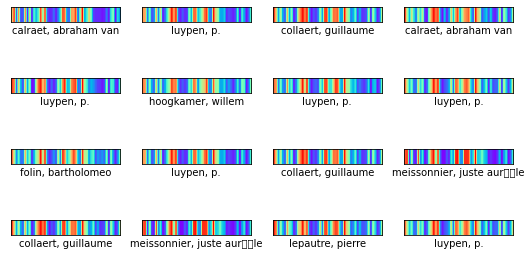

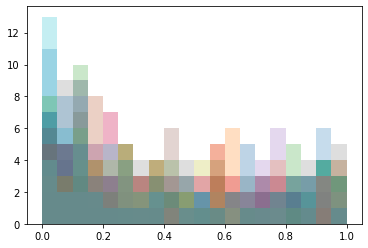

In [12]:
aggregate_vectors, artistnames = get_aggregrate_vectors(vectors=vectors,labels=labels)
plot_aggregates(aggregate_vectors,artistnames,n=4)
plot_aggregate_dist(aggregate_vectors)

In [13]:
# Query Image Removal Function
def query_image_remover(qi_vec, avg_vec, artnum):
    new_vec = (avg_vec - (qi_vec * (1/artnum))) * (artnum/(artnum-1))
    return new_vec

In [14]:
print(vectors)

[[4.81768578e-01 1.00000000e+00 7.80961636e-06 ... 1.06906316e-06
  8.62611705e-06 2.01272994e-01]
 [9.28468466e-01 9.96943355e-01 1.85087353e-01 ... 1.04873116e-05
  1.61699265e-01 2.85071433e-02]
 [9.99999762e-01 1.00000000e+00 1.01613204e-10 ... 1.70236575e-07
  1.34015011e-06 1.28898025e-03]
 ...
 [4.58296781e-05 1.12428665e-02 9.98093367e-01 ... 1.17188037e-07
  9.89794254e-01 9.73606944e-01]
 [2.07707554e-01 1.00000000e+00 4.61506583e-10 ... 4.36426983e-09
  1.43652856e-01 6.25115633e-01]
 [9.99364376e-01 3.46685052e-02 2.42751837e-03 ... 2.85394577e-07
  1.89260300e-05 4.19476211e-01]]


In [15]:
NUM_EXAMPLE = 20
train_val_split=0.8
dev_split = 0.1

total_bc = np.bincount(labels) # get count of artists
artcounts = total_bc[np.unique(labels)] # get count of artworks for each unique artist
artistnames = names[np.unique(labels)] # get the name for each unique artist

aggregate_vectors = []
artistnums = []
# iterate through each artist
for i in range(len(artcounts)):
    artistnum = np.unique(labels)[i] # Gets the number that represents this artist from labels
    artistnums.append(artistnum)
    
    artistname = artistnames[i] # Gets artist name as string
    artcount = artcounts[i] # Gets number of art pieces by this artist

    # get indicies of artist's artwork
    pos_idx = np.where(labels == artistnum)

    aggregate_vector = np.mean(vectors[pos_idx],axis=0)

    # store aggregrate vectors for each artist
    aggregate_vectors.append(aggregate_vector)


aggregate_vectors = np.array(aggregate_vectors)

# Generate pairs
total_pairs = np.zeros(shape=(len(labels)*2,2))
total_labels = np.zeros(shape=(len(labels)*2,1))

j = 0
for i in range(len(artcounts)):
    artistnum = np.unique(labels)[i]
    artcount = artcounts[i]

    #Retreiving negative and positive indices
    pos_idx = np.where(labels == artistnum)[0]
    neg_idx = np.where(labels != artistnum)[0]


    #Adding Positive Pairs for a given artist
    for idx in pos_idx:
        #print('j:',j)
        #print('total pairs:', total_pairs)
        #print('idx:',idx)
        #print('artistnum:',artistnum)
        total_pairs[j,:] = [idx,artistnum]
        total_labels[j] = 1
        j = j + 1

    #Adding Negative Pairs for a given artist
    neg_selec = np.random.choice(neg_idx,artcount,replace=False)
    for idx in neg_selec:
        total_pairs[j,:] = [idx,artistnum]
        total_labels[j] = 0
        j = j + 1

# Create and Test Split Order
goodbalance = False
spltest_labels = labels

while goodbalance == False:

    #Shuffle data
    mixer = np.arange(len(labels))
    np.random.shuffle(mixer)
    total_pairs = total_pairs[mixer,:]
    total_labels = total_labels[mixer]

    #Make Cutoffs
    train_cutoff = int(len(total_pairs) * train_val_split)
    dev_cutoff = int(len(total_pairs) * (train_val_split + dev_split))

    #Test Splits for Balance
    spltest_labels = spltest_labels[mixer]
    train_spltest = spltest_labels[:train_cutoff]
    dev_spltest = spltest_labels[train_cutoff:dev_cutoff]
    val_spltest = spltest_labels[dev_cutoff:]

    train_bc = np.bincount(train_spltest)
    dev_bc = np.bincount(dev_spltest)
    val_bc = np.bincount(val_spltest)

    check_bool = np.array([],dtype=bool)

    for i in np.unique(labels):
        if (len(np.unique(spltest_labels)) == len(np.unique(train_spltest))) and (len(np.unique(spltest_labels)) == len(np.unique(dev_spltest))) and (len(np.unique(spltest_labels)) == len(np.unique(train_spltest))):
            train_check = abs(total_bc[i]*0.8 - train_bc[i]) >= total_bc[i]*0.2 
            dev_check = abs(total_bc[i]*0.1 - dev_bc[i]) >= total_bc[i]*0.08
            val_check = abs(total_bc[i]*0.1 - val_bc[i]) >= total_bc[i]*0.08 
            check_bool = np.append(check_bool,(train_check or dev_check or val_check))

        elif total_bc[i] != 0:
            check_bool = np.append(check_bool,False)

    if sum(check_bool) <= 0:
        goodbalance = True

# Turn Pairs of Indices into Pairs of Vectors
final_pairs = []
for i, total_pair in enumerate(total_pairs):
    
    # get query vector index
    vector_idx = int(total_pair[0])
    
    # get aggregrate index  
    aggregrate_idx = np.where(artistnums==total_pair[-1])[0][0]

    # get 
    aggregrate_vector = aggregate_vectors[aggregrate_idx]
    query_vector = vectors[vector_idx]

    final_pair = np.array([aggregrate_vector,vector]).T
    final_pairs.append(final_pair)

final_pairs = np.array(final_pairs)
print(final_pairs.shape)
# Split Pairs x
train_pairs = final_pairs[:train_cutoff,:,:]
train_labels = total_labels[:train_cutoff]

dev_pairs = final_pairs[train_cutoff:dev_cutoff,:,:]
dev_labels = total_labels[train_cutoff:dev_cutoff]

val_pairs = final_pairs[dev_cutoff:,:,:]
val_labels = total_labels[dev_cutoff:]



<ipython-input-15-66ec4647dd8f>:110: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  aggregrate_idx = np.where(artistnums==total_pair[-1])[0][0]


IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
np.unique(labels)

In [ ]:
np.unique(total_pairs[:,1])